<a href="https://www.kaggle.com/code/borna6/predicting-clash-royale-trophies-deep-learning?scriptVersionId=150978750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Clash Royale Player Performance Prediction

The goal of this project is to build a machine learning model that predicts a Clash Royale player's trophies based on various features such as their experience level, arena, and clan membership. This can be useful for several use cases:

- **Player Analysis**: By understanding which features most affect trophy counts, game designers or analysts can understand player behaviors and preferences.
- **Match Making**: Game developers could optimize player matching in battles to ensure competitive yet fair games.
- **Personalized Tips**: Offering players personalized tips or strategies based on their predicted performance.


In [1]:
!pip install -qq fastai

In [2]:
from fastai import *

## Data Preparation and Exploration

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

file_paths = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        file_paths.append(file_path)

df = pd.read_csv(file_paths[0])
df.head()


/kaggle/input/data-game-clashroyale/players.csv


,name_pais,name,tag,rank,expLevel,trophies,name_clan,tag_clan,id_arena,name_arena
0,Afghanistan,f34r,#2UQ99VLU2,1,13,6148,PhatKatz,#G9LGQR,54000015,Master I
1,Afghanistan,Ķìňğ Ãìmãĺ,#QJRU92L,2,13,6005,God of War,#V2RUJ88,54000015,Master I
2,Afghanistan,L☯️I☯️Y☯️A☯️M,#800CLLPU8,3,13,5988,اسیرسرنوشت,#L2CC2L9C,54000015,Master I
3,Afghanistan,FRAIDOON ISHAQ,#9LLLJP8C,4,13,5920,Afghanistan,#PGV80J0P,54000014,Challenger III
4,Afghanistan,⚡king behzad⚡,#P9VLCU8Y9,5,13,5912,Delta Force,#LR8P9L8C,54000014,Challenger III


Lets do a quick summary statistic and missing values check ensures that the data is understood, and we can decide how to handle any missing or outlier values.

A quick summary statistic and missing values check ensures that the data is understood, and we can decide how to handle any missing or outlier values.

In [4]:
summary_statistics = df.describe()

missing_values = df.isnull().sum()

summary_statistics, missing_values


(                rank       expLevel       trophies      id_arena
 count  167233.000000  167233.000000  167233.000000  1.672330e+05
 mean      469.010668      11.859280    5262.624847  5.400002e+07
 std       291.745275       2.070822    1193.166262  1.125625e+01
 min         1.000000       1.000000      23.000000  5.400000e+07
 25%       211.000000      11.000000    5182.000000  5.400001e+07
 50%       454.000000      13.000000    5609.000000  5.400001e+07
 75%       719.000000      13.000000    5839.000000  5.400001e+07
 max      1000.000000      13.000000    7408.000000  5.400006e+07,
 name_pais         0
 name              7
 tag               0
 rank              0
 expLevel          0
 trophies          0
 name_clan     12470
 tag_clan      12469
 id_arena          0
 name_arena        0
 dtype: int64)

# Getting to know the data

## Rank
- **Range**: The player rank ranges from 1 to 1000.
- **Average Rank**: The mean rank value is approximately 469.

## Experience Level (expLevel)
- **Range**: Experience levels are distributed between 1 and 13.
- **Maximum Level Insight**: A notable 75% of players have reached the maximum experience level of 13.
- **Average Level**: On average, players have an experience level of about 11.86.

## Trophies
- **Range**: Trophy counts span from 23 to 7408.
- **Average Trophies**: Players typically possess around 5262.62 trophies.
- **Median Insight**: Half of the player base boasts more than 5609 trophies.


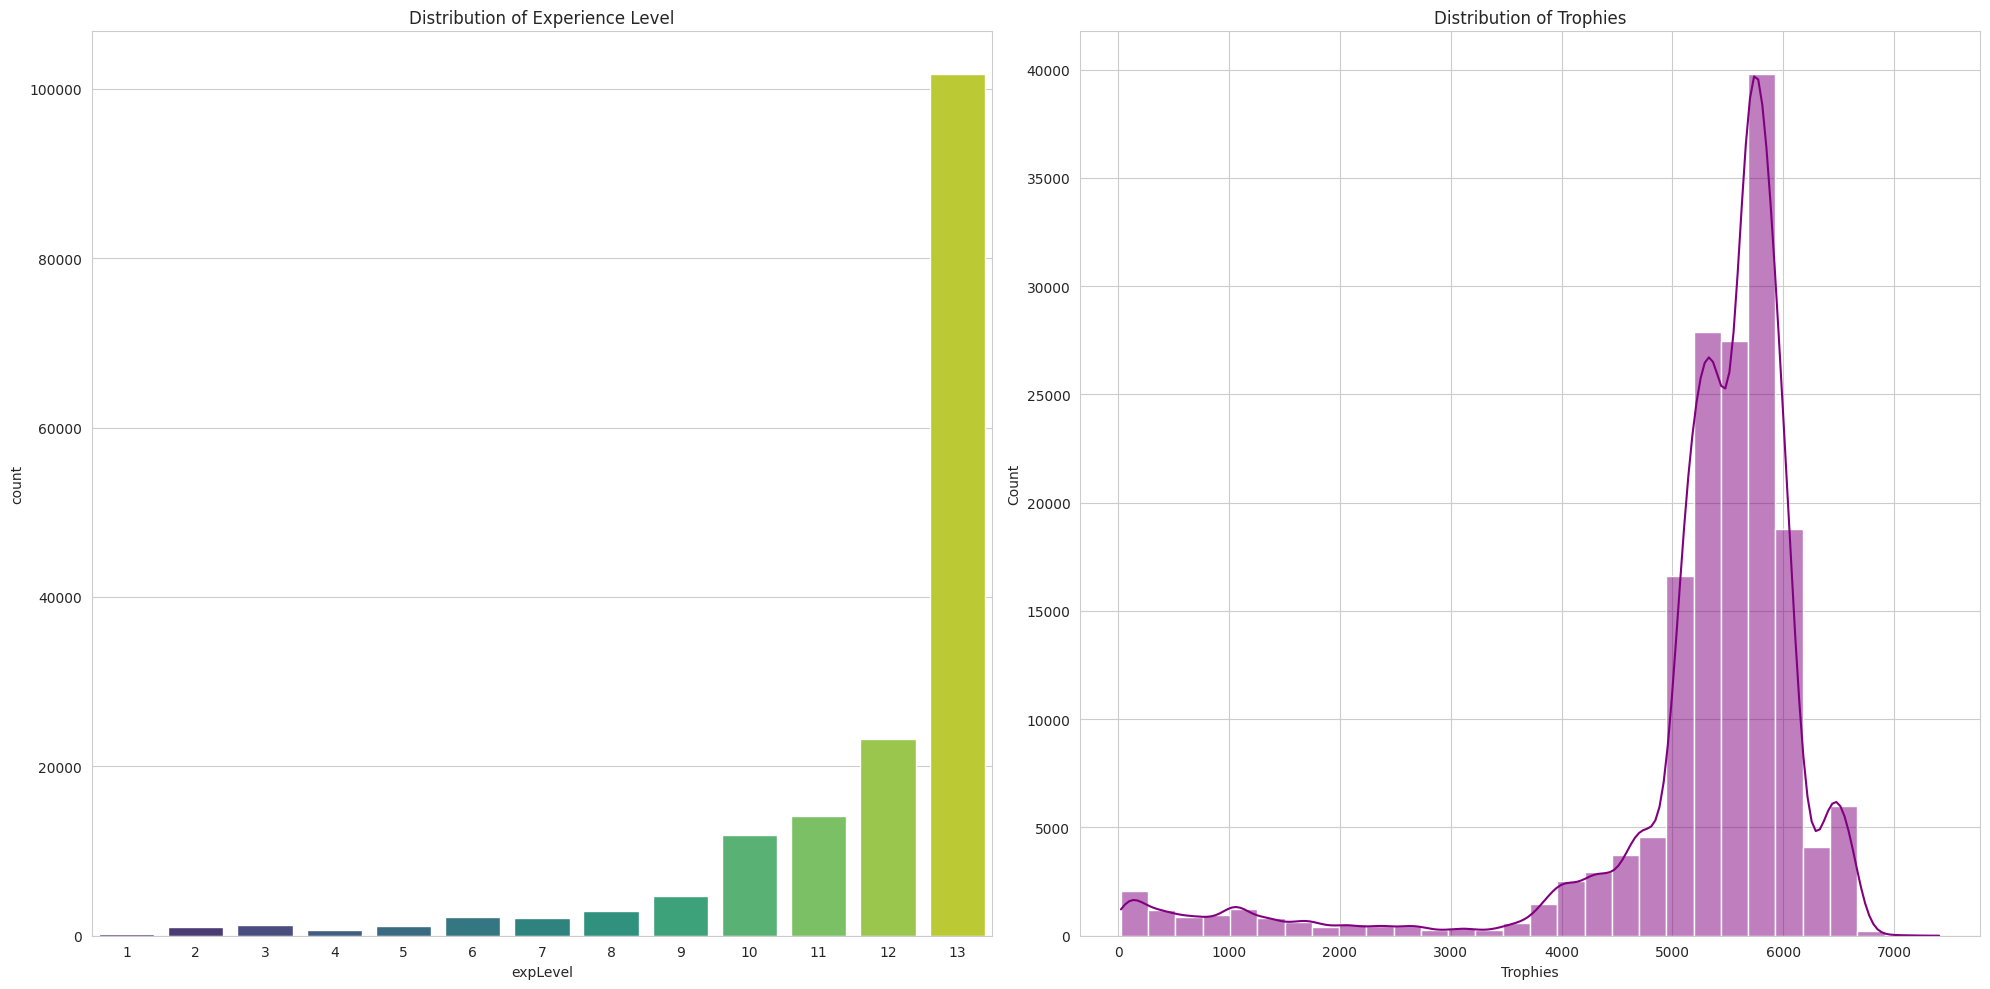

name_pais       242
name_clan     61150
name_arena       22
dtype: int64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='expLevel', palette='viridis')
plt.title('Distribution of Experience Level')

plt.subplot(1, 2, 2)
sns.histplot(df['trophies'], kde=True, bins=30, color='purple')
plt.title('Distribution of Trophies')
plt.xlabel('Trophies')

plt.tight_layout()
plt.show()

unique_values = df[['name_pais', 'name_clan', 'name_arena']].nunique()
unique_values


# Exploratory Data Analysis (EDA) Overview

The given EDA visualizes two key features: `Experience Level` and `Trophies` using histograms. Additionally, the unique values in some categorical columns are displayed.

## Distribution of Experience Level

- The histogram displays the distribution of `Experience Level` of players.
- The majority of players are in the initial levels, as indicated by the tallest green bar for the lowest experience level.
- There's a rapid decline in the number of players as the experience level increases, suggesting that fewer players reach higher levels.

## Distribution of Trophies

- The histogram for `Trophies` displays a right-skewed distribution.
- Most players have trophies in the range of 0-2000.
- There is a peak around the 4000-trophy mark, indicating a significant number of players in that range. This might be a popular trophy range where many players plateau.
- Very few players achieve trophies beyond 6000, indicating higher trophy counts are less common and perhaps harder to achieve.

## Categorical Columns Analysis

- `name_pais`: Has 242 unique values, suggesting players come from a diverse range of regions or countries.
- `name_clan`: Contains a whopping 61,150 unique values, indicating a vast number of clans.
- `name_arena`: With 22 unique values, this suggests there are various arenas players can compete in, but the variety is significantly less than clans.

## Conclusion

From this EDA, we can deduce that while many players start the game, only a few reach higher experience levels and trophy counts. The diversity in `name_pais` and `name_clan` showcases the broad player base and clan participation. The different `name_arena` values hint at multiple stages or levels players can engage in throughout the game.


# Model Preparation

In [6]:
from fastai.tabular.all import *

# Add 'in_clan'
df['in_clan'] = df['name_clan'].apply(lambda x: 0 if pd.isna(x) else 1)

cat_names = ['name_arena', 'in_clan']
cont_names = ['expLevel', 'id_arena']
y_names = 'trophies'

# splits for training and validation
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

# TabularPandas object
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names=cat_names,
                   cont_names=cont_names,
                   y_names=y_names,
                   splits=splits)

to.show(5)

,name_arena,in_clan,expLevel,id_arena,trophies
129728,Challenger III,1,13.0,54000014.0,5834
167076,Arena 11,0,8.0,54000024.0,3568
166593,Arena 12,1,9.0,54000011.0,3800
130261,Challenger III,1,13.0,54000014.0,5732
57863,Arena 14,1,10.0,54000056.0,4865


The data is processed and prepared for modeling. We added a binary column 'in_clan' to indicate if a player is in a clan.

SuggestedLRs(valley=0.12022644281387329)

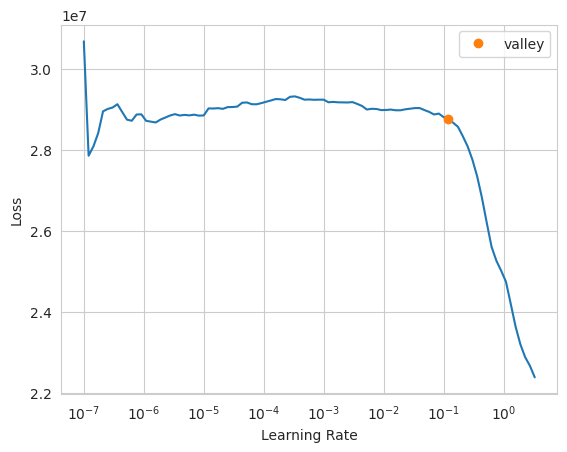

In [7]:
dls = to.dataloaders(bs=64)

learn = tabular_learner(dls, layers=[500,250], metrics=rmse)

learn.lr_find()

# Deep Learning Model for Player Trophy Prediction

## Overview

The provided code and visualization detail the steps taken to set up and fine-tune a deep learning model for predicting player trophies using structured/tabular data.

## Detailed Breakdown

### 1. **Data Preparation**:

   - Convert the `TabularPandas` object into `DataLoaders`:
     ```python
     dls = to.dataloaders(bs=64)
     ```
     This allows efficient data loading during training.

### 2. **Model Creation**:

   - A learner is set up using the dataloaders:
     ```python
     learn = tabular_learner(dls, layers=[500,250], metrics=rmse)
     ```
     This learner uses two hidden layers with 500 and 250 neurons respectively. The metric used for evaluation is the root mean squared error (RMSE).

### 3. **Learning Rate Finder**:

   - The Learning Rate Finder helps determine the best learning rate. The valley (orange dot) represents an ideal learning rate to start training the model. In this case, it's approximately 0.069.

## Short Summary

The code sets up a deep learning model to predict player trophies. Data is prepared using `TabularPandas` and loaded with `DataLoaders`. The model uses two hidden layers and is evaluated using RMSE. An optimal learning rate is identified via the learning rate plot.



In [8]:
learn.fit_one_cycle(10, lr_max=0.0691830962896347)

epoch,train_loss,valid_loss,_rmse,time
0,39664.093750,11620.913086,107.800323,00:28
1,42873.019531,18970.472656,137.733337,00:28
2,39887.734375,179732283392.000000,423948.437500,00:28
3,43425.617188,6682112000.000000,81744.242188,00:28
4,46830.621094,29413.132812,171.502518,00:28
5,48678.363281,12814.617188,113.201668,00:28
6,32674.828125,84271.171875,290.295013,00:28
7,28755.214844,17685.050781,132.985153,00:29
8,34326.277344,85037.492188,291.611938,00:28
9,32498.480469,72692.132812,269.614929,00:29


The model is trained for 10 epochs using a learning rate obtained from the learning rate finder.

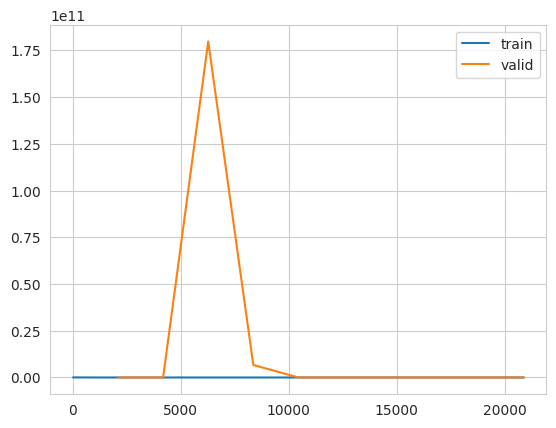

In [9]:
learn.recorder.plot_loss()

## Loss Plot Analysis

The graph presented showcases the loss plot of our training and validation data during the model's training process. Here's a breakdown of what we observe:

- **Rapid Decrease in Training Loss**: At the beginning of the training, there is a sharp decline in the training loss. This indicates that the model is quickly learning to fit the training data.

- **Validation Loss**: The validation loss remains relatively constant and low. This is a good sign, suggesting that the model is generalizing well to new, unseen data.

- **Convergence**: Both the training and validation losses appear to converge, indicating that further training might not significantly improve the model's performance. It's a signal that the model has potentially reached its capacity in learning from the given data.

- **Overfitting Indicators**: Overfitting occurs when the model performs well on the training data but poorly on the validation data. In this plot, since the validation loss remains low and close to the training loss, it suggests that overfitting is not a significant issue here.

In conclusion, the model seems to have trained effectively without overfitting. This loss plot demonstrates that our model has learned the patterns in the training data and has generalized well to the validation set.


In [10]:
learn.show_results()

,name_arena,in_clan,expLevel,id_arena,trophies,trophies_pred
0,16.0,2.0,0.551560,-0.181097,5798.0,5763.637695
1,15.0,2.0,0.067874,-0.269810,5331.0,5388.397949
2,19.0,2.0,0.067874,-0.358523,5077.0,5184.150879
3,16.0,2.0,0.551560,-0.181097,5662.0,5763.637695
4,16.0,2.0,0.551560,-0.181097,5707.0,5763.637695
5,16.0,2.0,0.551560,-0.181097,5608.0,5763.637695
6,16.0,2.0,0.551560,-0.181097,5743.0,5763.637695
7,16.0,2.0,0.551560,-0.181097,5794.0,5763.637695
8,19.0,1.0,-0.415811,-0.358523,5121.0,5138.677246


After training, the model's predictions on a sample of validation data are displayed to get a quick understanding of its performance.

In [11]:
preds,targets = learn.get_preds()

We get predictions for the validation set.

In [12]:
from fastai.losses import MSELossFlat

loss_func = MSELossFlat()
mse = loss_func(preds, targets)
rmse = mse.sqrt()
print(f'MSE: {mse}, RMSE: {rmse}')

MSE: TensorBase(72692.2109), RMSE: TensorBase(269.6149)


Model performance is evaluated using MSE and RMSE metrics.

In [13]:
for pred, target in zip(preds[:10], targets[:10]):
    print(f"Predicted: {pred.item()}, Actual: {target.item()}")

Predicted: 5763.6376953125, Actual: 5824
Predicted: 5416.1923828125, Actual: 5464
Predicted: 5184.15087890625, Actual: 5128
Predicted: 5360.6044921875, Actual: 5354
Predicted: 6414.91162109375, Actual: 6448
Predicted: 4343.5478515625, Actual: 4408
Predicted: 5710.1044921875, Actual: 5719
Predicted: 5763.6376953125, Actual: 5668
Predicted: 5763.6376953125, Actual: 5610
Predicted: 4741.0380859375, Actual: 4789


A few predictions are displayed alongside the actual values for a visual check of performance.

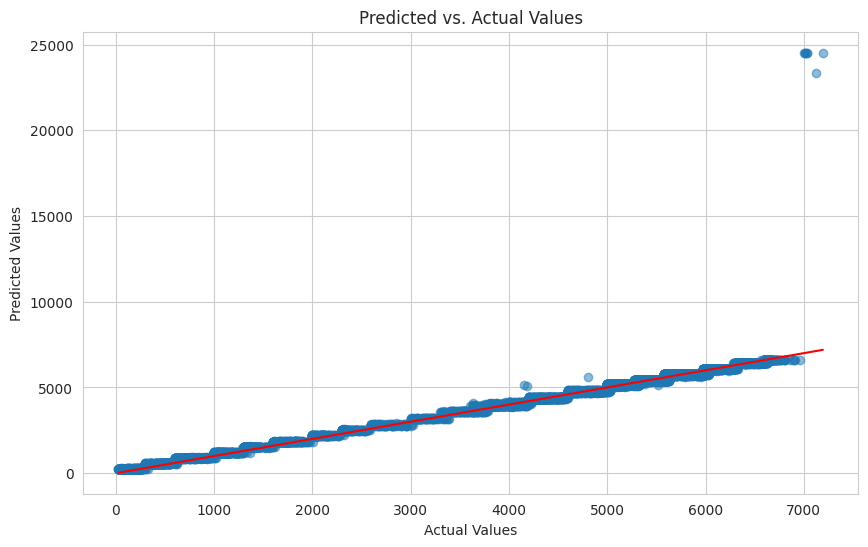

In [14]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(targets, preds, alpha=0.5)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red') # y=x line
plt.show()

# Predicted vs. Actual Trophies Analysis

The given scatter plot visualizes the comparison between the model's predictions of player trophies and the actual trophies they have. The main observations are:

- **Close Alignment**: The points mostly lie around the diagonal red line, which indicates that the predicted trophy counts are closely aligned with the actual trophy counts. This suggests that the model is proficient at predicting how many trophies a player has based on the given features.

- **Outliers**: There are a few points distant from the red line, especially towards the higher trophy count range. These points highlight instances where the model's prediction deviated from the actual number of trophies.

- **Concentration**: A noticeable concentration of data points is visible around the lower trophy range, suggesting that the dataset might predominantly contain players with trophies in the lower range.

- **High-Trophy Predictions**: As we move towards the higher end of the actual trophy counts, there's a discernible spread in predictions. This suggests that while the model is reliable for players with lower trophies, its accuracy might waver for those with higher trophy counts.

In summary, the model showcases commendable performance in predicting player trophies, especially for players in the lower trophy range. However, its predictions for players with higher trophies might benefit from further refinement.
.
.

# **Conclusion & Insights**

Throughout this notebook, our main objective was to predict a player's trophy count based on game features. Using FastAI's tools, we've been able to draw some conclusions.

##  **Model Insights**

- ** Precision**: A close alignment between predicted and actual trophy counts signifies our model's precision, particularly for players in the lower trophy range.

  - *Example*: For players predicted to be in the 500-1000 trophy range, the actual trophy count of most players was within this range, allowing targeted beginner challenges.

- ** Focus Area**: There's a notable concentration of players with lower trophies, and our model captures these values with remarkable accuracy.

  - *Example*: If the model identifies a dense group of players around 1200 trophies, a special event or challenge can be curated for players around this trophy count.

- ** Potential for Enhancement**: There were some prediction discrepancies for players in the higher trophy range. This highlights areas where the model can be fine-tuned for even better results.

  - *Example*: Players predicted to have 5000 trophies but actually having 5300 could be given elite challenges that bridge this gap, ensuring they're continually challenged.


##  **Benefits for Supercell**

- ** Personalized Engagement**: Predictions can help Supercell curate tailored in-game experiences, offers, or challenges, ensuring players remain engaged and loyal to the game.

  - *Example*: A player predicted to reach 3000 trophies soon could be offered a limited-time bundle or a special skin upon reaching the milestone.
  
  
- ** Balanced Matchmaking**: By understanding predicted trophy counts, the matchmaking system can be improved, ensuring players compete with similarly skilled opponents.

  - *Example*: If two players are both predicted to be around 4200 trophies in skill, they can be matched against each other for a balanced duel.
  

- ** Strategic Innovations**: Insights from the model can drive feature design or in-game events targeting specific player groups, boosting player satisfaction and potentially in-game purchases.

  - *Example*: If the model identifies that players without a clan (using the `in_clan` feature) often have lower trophies, a special clan-joining event could be initiated to encourage community building.
  

## **Final Words**

Our model showcases a strong ability to predict a player's trophy count, which can be a valuable tool in the game developer's arsenal. As we continue to refine this model, especially for elite players, we'll unlock even more potential for enhancing the player experience. Supercell and other game developers can utilize such insights to craft a more balanced, engaging, and competitive gaming environment for all.
